In [2]:
pip install -r image_classification.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import shutil
from pathlib import Path

RAW_DATA_DIR = r"C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut"
DATASET_DIR = r"C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut_Diseases"
SPLITS = (0.8, 0.1, 0.1)
SEED = 42
random.seed(SEED)

def prepare_dataset():
    classes = os.listdir(RAW_DATA_DIR)
    print("[DEBUG] Found classes:", classes)

    for split in ["train", "val", "test"]:
        for cls in classes:
            Path(DATASET_DIR, split, cls).mkdir(parents=True, exist_ok=True)

    for cls in classes:
        # Navigate into the nested directory
        nested_dir = os.path.join(RAW_DATA_DIR, cls, cls)
        print(f"[DEBUG] Checking nested directory for {cls}: {nested_dir}")
        if os.path.isdir(nested_dir):
            images = os.listdir(nested_dir)
            print(f"[DEBUG] Found images in {nested_dir}: {images}")
            images = [f for f in images if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"[DEBUG] Filtered images: {images}")
            if images:
                random.shuffle(images)
                n = len(images)
                print(f"[DEBUG] Total images for {cls}: {n}")
                
                n_train = int(SPLITS[0] * n)
                n_val = int(SPLITS[1] * n)
                n_test = n - n_train - n_val

                splits = {
                    "train": images[:n_train],
                    "val": images[n_train:n_train + n_val],
                    "test": images[n_train + n_val:]
                }

                for split, files in splits.items():
                    for f in files:
                        src = os.path.join(nested_dir, f)
                        dst = os.path.join(DATASET_DIR, split, cls, f)
                        print(f"[DEBUG] Copying {src} to {dst}")
                        shutil.copy(src, dst)
            else:
                print(f"[WARNING] No valid images found in {nested_dir}")
        else:
            print(f"[WARNING] Nested directory {nested_dir} does not exist")

    print("[INFO] Dataset prepared at:", DATASET_DIR)

# Execute the function
prepare_dataset()

[DEBUG] Found classes: ['CCI_Caterpillars', 'CCI_Leaflets', 'Healthy_Leaves', 'WCLWD_DryingofLeaflets', 'WCLWD_Flaccidity', 'WCLWD_Yellowing']
[DEBUG] Checking nested directory for CCI_Caterpillars: C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut\CCI_Caterpillars\CCI_Caterpillars
[DEBUG] Found images in C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut\CCI_Caterpillars\CCI_Caterpillars: ['CCI_10_0_jpg.rf.041b1c4c936db7346c0e1cc66e687757.jpg', 'CCI_10_0_jpg.rf.3dd177f566df40db63c0b8715d30c033.jpg', 'CCI_10_0_jpg.rf.4213fa6363674e98425c19dbb952da2a.jpg', 'CCI_10_104_jpg.rf.5c3bbbe5bb16823713de92fa3647fc5a.jpg', 'CCI_10_104_jpg.rf.8e80a645817ecfbe965f6a86b4226a67.jpg', 'CCI_10_104_jpg.rf.bab262669ad7fe31d63d9e4ef0f06be6.jpg', 'CCI_10_112_jpg.rf.7757383e2977b0600131d8fc19981a34.jpg', 'CCI_10_144_jpg.rf.1f666d1e6395e1920433b78dcd6cf8ee.jpg', 'CCI_10_144_jpg.rf.6c99038ca837c90fbb58a3c1e562c8ca.jpg', 'CCI_10_144_jpg.rf.cd7366b0ccd7cf6f03092509980a31

In [35]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




In [29]:
DATASET_DIR = r"C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut_Diseases"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [30]:
def train_model():
    global model, train_classes
    
    # Enhanced data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )
    
    val_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_path = os.path.join(DATASET_DIR, "train")
    val_path = os.path.join(DATASET_DIR, "val")
    
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_directory(
        val_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )
    
    # Save the class order
    train_classes = list(train_gen.class_indices.keys())
    print("Training classes:", train_classes)
    
    # Compute class weights for imbalance
    labels = train_gen.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weights_dict)
    
    # Build custom CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(*IMG_SIZE, 3), padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(train_classes), activation="softmax")
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint("best_coconut_model.h5", monitor="val_loss", save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001)
    
    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[early_stop, checkpoint, reduce_lr]
    )
    
    model.save("coconut_model_final.h5")

In [36]:
def evaluate_model():
    global model, test_gen
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    test_path = os.path.join(DATASET_DIR, "test")
    
    if os.path.exists(test_path):
        test_gen = test_datagen.flow_from_directory(
            test_path,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode="categorical",
            shuffle=False,
            classes=train_classes
        )
        if test_gen.samples == 0:
            print("No images found in test directory.")
            return
        
        # Get true labels and predictions
        y_true = test_gen.classes
        y_pred_prob = model.predict(test_gen)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class accuracy
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        for i, class_name in enumerate(train_classes):
            accuracy = class_accuracy[i] if cm.sum(axis=1)[i] > 0 else 0.0  # Avoid division by zero
            print(f"Accuracy for {class_name}: {accuracy:.2%}")
        
        # Overall accuracy
        overall_accuracy = np.sum(y_pred == y_true) / len(y_true)
        print(f"Overall Test Accuracy: {overall_accuracy:.2%}")
        
        # Optional: Visualize confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_classes, yticklabels=train_classes)
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()
    else:
        print("No separate test set found.")

In [32]:
def predict_sample(img_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    classes = train_classes
    print(f"Prediction: {classes[pred.argmax()]}")
    return classes[pred.argmax()]

In [23]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [34]:
if __name__ == "__main__":
    train_model()
    evaluate_model()
    
    test_root = os.path.join(DATASET_DIR, "test")
    if os.path.exists(test_root) and train_classes:
        class_folder = random.choice(train_classes)
        img_file = random.choice(os.listdir(os.path.join(test_root, class_folder)))
        sample_image = os.path.join(test_root, class_folder, img_file)
        predict_sample(sample_image)

Found 5110 images belonging to 6 classes.
Found 1385 images belonging to 6 classes.
Training classes: ['CCI_Caterpillars', 'CCI_Leaflets', 'Healthy_Leaves', 'WCLWD_DryingofLeaflets', 'WCLWD_Flaccidity', 'WCLWD_Yellowing']
Class weights: {0: 0.8646362098138748, 1: 1.0794254330376003, 2: 6.924119241192412, 3: 0.7937247592420006, 4: 0.8011915961116337, 5: 0.790776849272671}


C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6513 - loss: 1.1260

160/160 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.6518 - loss: 1.1241 - val_accuracy: 0.1545 - val_loss: 12.6618 - learning_rate: 1.0000e-04
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8128 - loss: 0.5140

160/160 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.8130 - loss: 0.5136 - val_accuracy: 0.3451 - val_loss: 7.5742 - learning_rate: 1.0000e-04
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8753 - loss: 0.3290

160/160 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.8753 - loss: 0.3289 - val_accuracy: 0.6809 - val_loss: 1.4014 - learning_rate: 1.0000e-04
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8872 - loss: 0.3597

160/160 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8872 - loss: 0.3595 - val_accuracy: 0.9336 - val_loss: 0.2391 - learning_rate: 1.0000e-04
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9115 - loss: 0.2334 - val_accuracy: 0.8975 - val_loss: 0.3847 - learning_rate: 1.0000e-04
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8977 - loss: 0.3238

160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8978 - loss: 0.3236 - val_accuracy: 0.9661 - val_loss: 0.1119 - learning_rate: 1.0000e-04
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9298 - loss: 0.1882

160/160 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9298 - loss: 0.1882 - val_accuracy: 0.9726 - val_loss: 0.0896 - learning_rate: 1.0000e-04
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9336 - loss: 0.1794 - val_accuracy: 0.9285 - val_loss: 0.3104 - learning_rate: 1.0000e-04
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9290 - loss: 0.1913

160/160 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9290 - loss: 0.1912 - val_accuracy: 0.9690 - val_loss: 0.0866 - learning_rate: 1.0000e-04
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9529 - loss: 0.1360 - val_accuracy: 0.9379 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9579 - loss: 0.1162 - val_accuracy: 0.9365 - val_loss: 0.2133 - learning_rate: 1.0000e-04
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9540 - loss: 0.1146 - val_accuracy: 0.9704 - val_loss: 0.0973 - learning_rate: 1.0000e-04
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9528 - loss: 0.1075 - val_accuracy: 0.9495 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9534 - loss: 0.1234

160/160 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9534 - loss: 0.1234 - val_accuracy: 0.9783 - val_loss: 0.0833 - learning_rate: 1.0000e-04
Epoch 15/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9612 - loss: 0.1117 - val_accuracy: 0.9596 - val_loss: 0.1474 - learning_rate: 1.0000e-04
Epoch 16/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9666 - loss: 0.0936 - val_accuracy: 0.9134 - val_loss: 0.3502 - learning_rate: 1.0000e-04
Epoch 17/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9691 - loss: 0.0718 - val_accuracy: 0.9675 - val_loss: 0.1046 - learning_rate: 1.0000e-04
Epoch 18/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9500 - loss: 0.1377 - val_accuracy: 0.9329 - val_loss: 0.2729 - learning_rate: 1.0000e-04
Epoch 19/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9697 - loss: 0.0774 - val_accuracy: 0.9711 - val_loss: 0.0907 - learning_rate: 1.0000e-04
Epoch 20/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

160/160 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9769 - loss: 0.0665 - val_accuracy: 0.9928 - val_loss: 0.0306 - learning_rate: 2.0000e-05
Epoch 21/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9835 - loss: 0.0504

160/160 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9835 - loss: 0.0504 - val_accuracy: 0.9942 - val_loss: 0.0212 - learning_rate: 2.0000e-05
Epoch 22/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.9785 - loss: 0.0527 - val_accuracy: 0.9704 - val_loss: 0.0813 - learning_rate: 2.0000e-05
Epoch 23/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9792 - loss: 0.0504 - val_accuracy: 0.9899 - val_loss: 0.0290 - learning_rate: 2.0000e-05
Epoch 24/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9825 - loss: 0.0524 - val_accuracy: 0.9899 - val_loss: 0.0320 - learning_rate: 2.0000e-05
Epoch 25/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9859 - loss: 0.0392 - val_accuracy: 0.9711 - val_loss: 0.0801 - learning_rate: 2.0000e-05
Epoch 26/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.9855 - loss: 0.0384 - val_accuracy: 0.9863 - val_loss: 0.0310 - learning_rate: 2.0000e-05
Epoch 27/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy

160/160 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9877 - loss: 0.0306 - val_accuracy: 0.9935 - val_loss: 0.0199 - learning_rate: 1.0000e-05
Epoch 32/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9855 - loss: 0.0411 - val_accuracy: 0.9877 - val_loss: 0.0345 - learning_rate: 1.0000e-05
Epoch 33/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9892 - loss: 0.0289 - val_accuracy: 0.9913 - val_loss: 0.0204 - learning_rate: 1.0000e-05
Epoch 34/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9862 - loss: 0.0334 - val_accuracy: 0.9899 - val_loss: 0.0289 - learning_rate: 1.0000e-05
Epoch 35/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9881 - loss: 0.0305 - val_accuracy: 0.9899 - val_loss: 0.0276 - learning_rate: 1.0000e-05
Epoch 36/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9860 - loss: 0.0318 - val_accuracy: 0.9870 - val_loss: 0.0429 - learning_rate: 1.0000e-05
Epoch 37/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy

160/160 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.9913 - loss: 0.0264 - val_accuracy: 0.9935 - val_loss: 0.0195 - learning_rate: 1.0000e-05
Epoch 42/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9902 - loss: 0.0225

160/160 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9902 - loss: 0.0225 - val_accuracy: 0.9942 - val_loss: 0.0165 - learning_rate: 1.0000e-05
Epoch 43/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9918 - loss: 0.0267 - val_accuracy: 0.9928 - val_loss: 0.0178 - learning_rate: 1.0000e-05
Epoch 44/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9888 - loss: 0.0271 - val_accuracy: 0.9921 - val_loss: 0.0221 - learning_rate: 1.0000e-05
Epoch 45/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9894 - loss: 0.0381 - val_accuracy: 0.9928 - val_loss: 0.0185 - learning_rate: 1.0000e-05
Epoch 46/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9891 - loss: 0.0271

160/160 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.9891 - loss: 0.0271 - val_accuracy: 0.9942 - val_loss: 0.0141 - learning_rate: 1.0000e-05
Epoch 47/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9872 - loss: 0.0320 - val_accuracy: 0.9675 - val_loss: 0.0875 - learning_rate: 1.0000e-05
Epoch 48/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9919 - loss: 0.0214 - val_accuracy: 0.9921 - val_loss: 0.0210 - learning_rate: 1.0000e-05
Epoch 49/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.9874 - loss: 0.0326 - val_accuracy: 0.9899 - val_loss: 0.0343 - learning_rate: 1.0000e-05
Epoch 50/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9881 - loss: 0.0334 - val_accuracy: 0.9942 - val_loss: 0.0186 - learning_rate: 1.0000e-05


Found 1405 images belonging to 6 classes.
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 701ms/step - accuracy: 0.9971 - loss: 0.0067
Test accuracy: 99.64%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: CCI_Caterpillars


Loaded model from C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\models\coconut_model_final.h5
Found 1405 images belonging to 6 classes.


C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step
Accuracy for CCI_Caterpillars: 100.00%
Accuracy for CCI_Leaflets: 100.00%
Accuracy for Healthy_Leaves: 97.06%
Accuracy for WCLWD_DryingofLeaflets: 99.00%
Accuracy for WCLWD_Flaccidity: 99.66%
Accuracy for WCLWD_Yellowing: 100.00%
Overall Test Accuracy: 99.64%


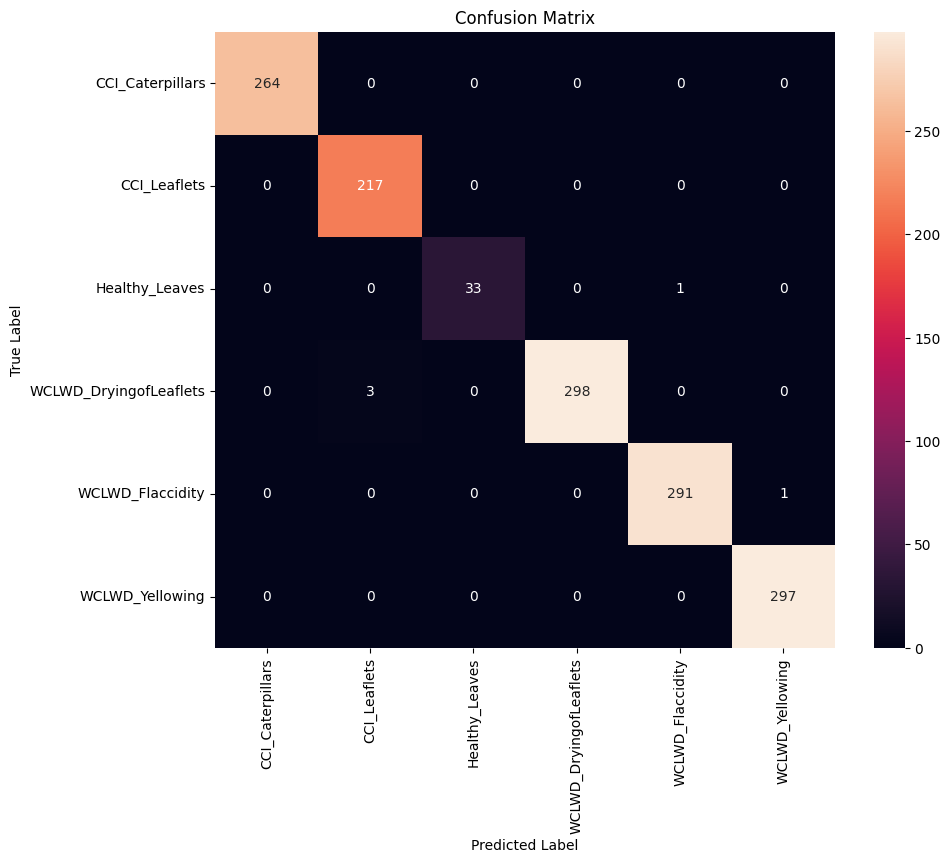

In [39]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define constants (match these with your training setup)
DATASET_DIR = r"C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\Dataset\Coconut_Diseases"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
MODEL_PATH = r"C:\Users\adity\AI-Driven_Coconut_Cultivation_Assistant\models\coconut_model_final.h5"  # Path to your saved model

# Manually set train_classes (update this based on your training output)
# Example: Replace with the exact class names printed during train_model
train_classes = [
    "CCI_Caterpillars",
    "CCI_Leaflets",
    "Healthy_Leaves",
    "WCLWD_DryingofLeaflets",
    "WCLWD_Flaccidity",
    "WCLWD_Yellowing"
]

def evaluate_model():
    global model, test_gen
    
    # Load the saved model
    model = load_model(MODEL_PATH)
    print(f"Loaded model from {MODEL_PATH}")
    
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    test_path = os.path.join(DATASET_DIR, "test")
    
    if os.path.exists(test_path):
        test_gen = test_datagen.flow_from_directory(
            test_path,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode="categorical",
            shuffle=False,
            classes=train_classes
        )
        if test_gen.samples == 0:
            print("No images found in test directory.")
            return
        
        # Get true labels and predictions
        y_true = test_gen.classes
        y_pred_prob = model.predict(test_gen)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class accuracy
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        for i, class_name in enumerate(train_classes):
            accuracy = class_accuracy[i] if cm.sum(axis=1)[i] > 0 else 0.0  # Avoid division by zero
            print(f"Accuracy for {class_name}: {accuracy:.2%}")
        
        # Overall accuracy
        overall_accuracy = np.sum(y_pred == y_true) / len(y_true)
        print(f"Overall Test Accuracy: {overall_accuracy:.2%}")
        
        # Visualize confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_classes, yticklabels=train_classes)
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()
    else:
        print("No separate test set found.")

if __name__ == "__main__":
    evaluate_model()